# Linear Discriminant Analysis
---
---

Both Linear Discriminant Analysis (LDA) and Principal Component Analysis (PCA) are linear transformation techniques that are commonly used for dimensionality reduction. PCA can be described as an “unsupervised” algorithm, since it “ignores” class labels and its goal is to find the directions (the so-called principal components) that maximize the variance in a dataset. In contrast to PCA, LDA is “supervised” and computes the directions (“linear discriminants”) that will represent the axes that that maximize the separation between multiple classes.

![PCA vs LDA](https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png)

Summarizing the LDA approach in 5 steps
---
---

Listed below are the 5 general steps for performing a linear discriminant analysis; we will explore them in more detail in the following sections.

1. `Compute the d-dimensional mean vectors` for the different classes from the dataset.
2. `Compute the scatter matrices` (in-between-class and within-class scatter matrix).
3. `Compute the eigenvectors` (ee1,ee2,...,eed
) and corresponding eigenvalues (λλ1,λλ2,...,λλd
) for the scatter matrices.
4. `Sort the eigenvectors by decreasing eigenvalues and choose k`
 eigenvectors with the largest eigenvalues to form a d×k
 dimensional matrix WW
 (where every column represents an eigenvector).
5. `Use this d×k eigenvector matrix to transform the samples onto the new subspace.` This can be summarized by the matrix multiplication: 
`YY=XX×WW`
 (where XX is a n×d-dimensional matrix representing the n samples, and yy are the transformed n×k-dimensional samples in the new subspace).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

In [39]:
df = pd.read_csv('AB_NYC_2019.csv')

In [40]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [41]:
# drop id, name, host_id, host_name, neighborhood, latitude, longitude, room_type, last_review
df = df.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'neighbourhood_group', 'latitude', 'longitude', 'room_type', 'last_review'], axis=1)

In [42]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,149,1,9,0.21,6,365
1,225,1,45,0.38,2,355
2,150,3,0,NaN,1,365
3,89,1,270,4.64,1,194
4,80,10,9,0.10,1,0


In [43]:
# check for nan values
df.isnull().sum()

price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [44]:
# reviews_per_month = 0.01 where number of reviews is 0 or nan
df['reviews_per_month'] = df['reviews_per_month'].fillna(0.01)

In [45]:
# check for nan values
df.isnull().sum()

price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [46]:
# number of reviews = 0.01 where number of reviews is 0
df['number_of_reviews'] = df['number_of_reviews'].replace(0, 0.01)

In [47]:
df.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,149,1,9.00,0.21,6,365
1,225,1,45.00,0.38,2,355
2,150,3,0.01,0.01,1,365
3,89,1,270.00,4.64,1,194
4,80,10,9.00,0.10,1,0


In [52]:
df.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720912,7.029962,23.276522,1.092966,7.143982,112.784913
std,240.154027,20.510550,44.549508,1.595883,32.952519,131.619216
min,1.000000,1.000000,0.010000,0.010000,1.000000,0.010000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.010000
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [49]:
# price is 1 where price is 0
df['price'] = df['price'].replace(0, 1)

In [51]:
df['availability_365'] = df['availability_365'].replace(0, 0.01)

In [53]:
# import min max scaler
from sklearn.preprocessing import MinMaxScaler

In [54]:
#min max scaler for all numerical features
def min_max_scaler(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

#standard scaler for all numerical features

In [57]:
df_LDA = pd.DataFrame(min_max_scaler(df), columns=df.columns)


In [61]:
# log transform function
def log_transform(x):
    return np.log(x + 1)
# inverse log transform function

In [66]:
df_LDA = pd.DataFrame(log_transform(df), columns=df.columns)

In [67]:
df_LDA.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,5.010635,0.693147,2.302585,0.190620,1.945910,5.902633
1,5.420535,0.693147,3.828641,0.322083,1.098612,5.874931
2,5.017280,1.386294,0.009950,0.009950,0.693147,5.902633
3,4.499810,0.693147,5.602119,1.729884,0.693147,5.273000
4,4.394449,2.397895,2.302585,0.095310,0.693147,0.009950


In [72]:
df_LDA.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,4.737041,1.499881,1.992820,0.544686,1.087216,2.997612
std,0.694359,0.869823,1.561585,0.575859,0.858668,2.458088
min,0.693147,0.693147,0.009950,0.009950,0.693147,0.009950
25%,4.248495,0.693147,0.693147,0.039221,0.693147,0.009950
50%,4.672829,1.386294,1.791759,0.314811,0.693147,3.828641
75%,5.170484,1.791759,3.218876,0.947789,1.098612,5.429346
max,9.210440,7.131699,6.445720,4.085976,5.793014,5.902633


In [73]:
# create new column called class 
# class values are cheap, medium, expensive based on price as percentiles
df_LDA['class'] = pd.qcut(df_LDA['price'], q=3, labels=['cheap', 'medium', 'expensive'])

In [74]:
df_LDA.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,class
0,5.010635,0.693147,2.302585,0.190620,1.945910,5.902633,medium
1,5.420535,0.693147,3.828641,0.322083,1.098612,5.874931,expensive
2,5.017280,1.386294,0.009950,0.009950,0.693147,5.902633,medium
3,4.499810,0.693147,5.602119,1.729884,0.693147,5.273000,medium
4,4.394449,2.397895,2.302585,0.095310,0.693147,0.009950,cheap


In [99]:
# select target and predictor variables
y = df_LDA.loc[:, 'price']
X = df_LDA.loc[:, 'minimum_nights':'availability_365']

In [95]:
# target names
lda_feature_names = list(set(df_LDA['class']))

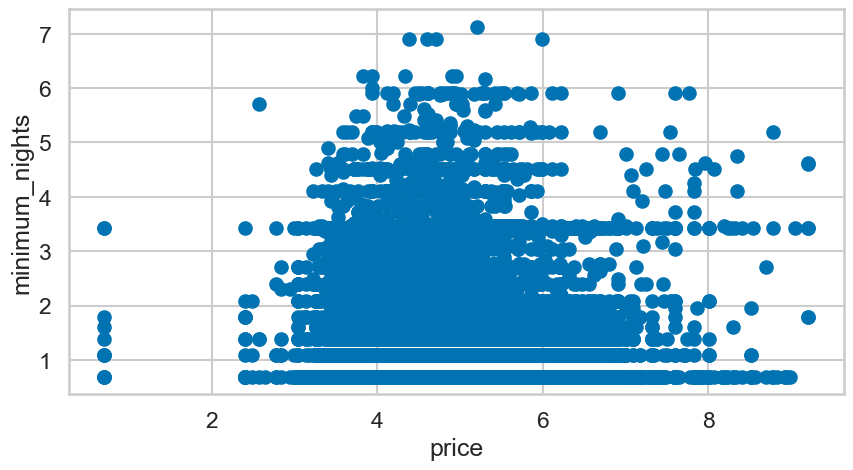

In [98]:
# scatter plot of price and minimum_nights
plt.figure(figsize=(10, 5))
plt.scatter(df_LDA['price'], df_LDA['minimum_nights'])
plt.xlabel('price')
plt.ylabel('minimum_nights')
plt.show()

In [100]:
#perform LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X, y)
X_reduced = lda.transform(X)

ValueError: Unknown label type: (array([5.01063529, 5.420535  , 5.01727984, ..., 4.75359019, 4.02535169,
       4.51085951]),)